# LLF_tidy_images - Extended Recruitment Experiment

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import os

from proglearn.forest import LifelongClassificationForest
from sklearn.model_selection import train_test_split

## FTE/BTE Experiment

### Check Imports

In [2]:
dataset_name = "food_101_array_data_x_1"
load = np.load(dataset_name + '.npz')

print(load['arr_0'][0].shape)
print(len(load['arr_0']))

(32, 32, 3)
34000


In [3]:
dataset_name = "dtd_array_data_x"
load = np.load(dataset_name + '.npz')

print(load['arr_0'][0].shape)
print(len(load['arr_0']))

(32, 32, 3)
4800


In [4]:
dataset_name = '101_ObjectCategories'
load = np.load(dataset_name + '.npz')

print(load['imgs'][0].shape)
print(len(load['imgs']))
print(len(load['lbls']))

(32, 32, 3)
9144
9144


In [5]:
labels = pd.Index(load['lbls'])
labels.value_counts()

16    800
79    798
91    467
44    435
95    435
     ... 
39     34
71     34
74     33
98     32
96     31
Length: 102, dtype: int64

In [6]:
labels.value_counts()[labels.value_counts()>=50]

16    800
79    798
91    467
44    435
95    435
     ... 
69     52
8      51
33     51
42     50
68     50
Length: 68, dtype: int64

### Preprocess Data

In [3]:
data = []
labels = []

# import datasets that emily preprocessed
for set1 in ['101_ObjectCategories', 'CIFAR_10', 'CIFAR_100']:
    # load from npz
    load = np.load(set1 + '.npz')
    # reformat and append
    data.append(load['imgs'].reshape(len(load['imgs']), -1).astype(np.uint8))
    labels.append(load['lbls'].astype(np.uint16))

# import datasets that rahul preprocessed
food_101 = np.empty((0,32*32*3), np.uint8)
for set2 in ['food_101_array_data_x_1', 'food_101_array_data_x_2', 'food_101_array_data_x_3']:
    # load from npz
    load = np.load(set2 + '.npz')
    # reformat and append
    food_101 = np.vstack((food_101,load['arr_0'].reshape(len(load['arr_0']), -1).astype(np.uint8)))
data.append(food_101)
labels.append(np.concatenate([([i]*1000) for i in list(range(100))], axis=0).astype(np.uint16))
# load from npz
load = np.load('dtd_array_data_x.npz')
# reformat and append
data.append(load['arr_0'].reshape(len(load['arr_0']), -1).astype(np.uint8))
labels.append(np.concatenate([([i]*120) for i in list(range(40))], axis=0).astype(np.uint16))
labels

[array([  0,   0,   0, ..., 101, 101, 101], dtype=uint16),
 array([6, 9, 9, ..., 5, 1, 7], dtype=uint16),
 array([19, 29,  0, ..., 51, 42, 70], dtype=uint16),
 array([ 0,  0,  0, ..., 99, 99, 99], dtype=uint16),
 array([ 0,  0,  0, ..., 39, 39, 39], dtype=uint16)]

In [4]:
# modify labels
labels2 = []
for idx, lbl_set in enumerate(labels):
    if idx == 0:
        labels2.append(labels[idx])
    else:
        counter = 0
        for i in range(idx):
            counter += len(np.unique(labels[i]))
        labels2.append(labels[idx] + counter)
labels = labels2
labels

[array([  0,   0,   0, ..., 101, 101, 101], dtype=uint16),
 array([108, 111, 111, ..., 107, 103, 109], dtype=uint16),
 array([131, 141, 112, ..., 163, 154, 182], dtype=uint16),
 array([212, 212, 212, ..., 311, 311, 311], dtype=uint16),
 array([312, 312, 312, ..., 351, 351, 351], dtype=uint16)]

In [5]:
np.savez_compressed('GROUPED_DATA', imgs=data, lbls=labels)

### Reimport Data

In [3]:
load = np.load('GROUPED_DATA.npz', allow_pickle=True)
data = load['imgs']
labels = load['lbls']

### FTE/BTE Experiment

In [4]:
##### MAIN HYPERPARAMS ##################
model = "uf"
num_tasks = 5
num_trees = 10
#num_points_per_task = 500 #5000 # per dataset
reps = 30
#########################################

#### Run Experiment

In [5]:
x_data = data
y_data = labels

In [7]:
# initialize list for storing results
accuracies_across_tasks = []

# format data
if model == 'dnn':
    x = x_data
    y = y_data
elif model == 'uf':
    x = x_data 
    y = y_data

# get y values per task
ys_by_task = [np.unique(i) for i in labels]

# get the count of the least frequent label over all tasks
min_labelct = np.min([np.min(np.unique(each_set, return_counts=True)[1]) for each_set in y_data])

# run experiment over all reps
for rep in range(reps):
    print('Starting rep', rep)
    
    train_x_task = []
    train_y_task = []
    test_x_task = []
    test_y_task = []
    
    # sample num_points_per_task from each dataset
    x_sample = []
    y_sample = []
    for dataset, label in zip(x, y):
        sample = []
        for unique_label in np.unique(label):
            sample += list(np.random.choice(np.where(label==unique_label)[0], min_labelct))
        x_sample.append(dataset[sample])
        y_sample.append(label[sample])
        
    # initialize overall learner
    learner = LifelongClassificationForest(default_n_estimators=num_trees, default_max_depth=30)

    # for each task
    for task in range(num_tasks):
        print('task', task)

        # get train/test data 
        tr_x, te_x, tr_y, te_y = train_test_split(x_sample[task], y_sample[task], test_size=0.2)
        train_x_task.append(tr_x)
        train_y_task.append(tr_y)
        test_x_task.append(te_x)
        test_y_task.append(te_y)
        
        # predict on single task (UF learner) - CHANGE TO UNCERTAINTYFOREST LATER
        uf_learner = LifelongClassificationForest(default_n_estimators=num_trees, default_max_depth=30)
        uf_learner.add_task(train_x_task[task], train_y_task[task])
        uf_predictions = uf_learner.predict(test_x_task[task], task_id=0)
        accuracies_across_tasks.append(np.mean(uf_predictions == test_y_task[task]))
        
        # feed to overall learner 
        learner.add_task(train_x_task[task], train_y_task[task])

        # evaluate for other tasks
        for other_task in range(num_tasks):

            if other_task > task:
                pass

            else:
                # predict on current task using other tasks
                prev_task_predictions = learner.predict(test_x_task[other_task], task_id=other_task)
                accuracies_across_tasks.append(np.mean(prev_task_predictions == test_y_task[other_task]))
        
# average results
accuracy_all_task = np.array(accuracies_across_tasks).reshape((reps, -1))
accuracy_all_task = np.mean(accuracy_all_task, axis = 0)

Starting rep 0
task 0
task 1
task 2
task 3
task 4
Starting rep 1
task 0
task 1
task 2
task 3
task 4
Starting rep 2
task 0
task 1
task 2
task 3
task 4
Starting rep 3
task 0
task 1
task 2
task 3
task 4
Starting rep 4
task 0
task 1
task 2
task 3
task 4
Starting rep 5
task 0
task 1
task 2
task 3
task 4
Starting rep 6
task 0
task 1
task 2
task 3
task 4
Starting rep 7
task 0
task 1
task 2
task 3
task 4
Starting rep 8
task 0
task 1
task 2
task 3
task 4
Starting rep 9
task 0
task 1
task 2
task 3
task 4
Starting rep 10
task 0
task 1
task 2
task 3
task 4
Starting rep 11
task 0
task 1
task 2
task 3
task 4
Starting rep 12
task 0
task 1
task 2
task 3
task 4
Starting rep 13
task 0
task 1
task 2
task 3
task 4
Starting rep 14
task 0
task 1
task 2
task 3
task 4
Starting rep 15
task 0
task 1
task 2
task 3
task 4
Starting rep 16
task 0
task 1
task 2
task 3
task 4
Starting rep 17
task 0
task 1
task 2
task 3
task 4
Starting rep 18
task 0
task 1
task 2
task 3
task 4
Starting rep 19
task 0
task 1
task 2
task

In [8]:
accuracy_all_task

array([0.40600316, 0.40442338, 0.22741935, 0.41858873, 0.22849462,
       0.09      , 0.44186414, 0.23548387, 0.10424731, 0.03075269,
       0.45576619, 0.23602151, 0.11010753, 0.04322581, 0.20174731,
       0.46129542, 0.23494624, 0.11489247, 0.04473118, 0.23454301])

In [9]:
# accuracy
err = [[] for i in range(num_tasks)]
for i in range(num_tasks):
    for j in range(i, num_tasks):
        err[i].append(1-accuracy_all_task[np.sum(list(range(1,j+2)))+i])

# backwards transfer efficiency
bte = [[] for i in range(num_tasks)]
for i in range(num_tasks):
    for j in range(i, num_tasks):
        err_up_to_taskt = 1-accuracy_all_task[np.sum(list(range(1,i+2)))+i]
        err_all_seen =    1-accuracy_all_task[np.sum(list(range(1,j+2)))+i]
        bte[i].append(err_up_to_taskt/err_all_seen)

# forwards transfer efficiency
fte = [[] for i in range(num_tasks)]
for i in range(num_tasks):
    err_taskt_only =  1-accuracy_all_task[np.sum(list(range(1,i+2)))-1]
    err_up_to_taskt = 1-accuracy_all_task[np.sum(list(range(1,i+2)))+i]
    fte[i].append(err_taskt_only/err_up_to_taskt)

# transfer efficiency
te = [[] for i in range(num_tasks)]
for i in range(num_tasks):
    for j in range(i, num_tasks):
        err_taskt_only =  1-accuracy_all_task[np.sum(list(range(1,i+2)))-1]
        err_all_seen =    1-accuracy_all_task[np.sum(list(range(1,j+2)))+i]
        te[i].append(err_taskt_only/err_all_seen)

In [10]:
fte

[[0.9973474801061007],
 [1.0013937282229968],
 [1.0159054078386651],
 [1.013036637446617],
 [1.042844600526778]]

In [11]:
bte

[[1.0,
  1.0243637351689159,
  1.0670818001698272,
  1.0943396226415092,
  1.105571847507331],
 [1.0, 1.0091420534458508, 1.0098522167487685, 1.0084328882642306],
 [1.0, 1.0065853069115516, 1.0120269695681223],
 [1.0, 1.0015758667266996],
 [1.0]]

In [12]:
te

[[0.9973474801061007,
  1.0216465899827913,
  1.0642513444664587,
  1.0914368650217703,
  1.1026392961876827],
 [1.0013937282229968,
  1.0105485232067513,
  1.011259676284307,
  1.0098383696416025],
 [1.0159054078386651, 1.0225954567423876, 1.0281236712628319],
 [1.013036637446617, 1.014633048176497],
 [1.042844600526778]]

In [13]:
err

[[0.5955766192733016,
  0.5814112690889941,
  0.5581358609794629,
  0.5442338072669827,
  0.5387045813586099],
 [0.771505376344086,
  0.7645161290322581,
  0.763978494623656,
  0.7650537634408602],
 [0.895752688172043, 0.8898924731182796, 0.8851075268817205],
 [0.9567741935483871, 0.9552688172043011],
 [0.7654569892473118]]

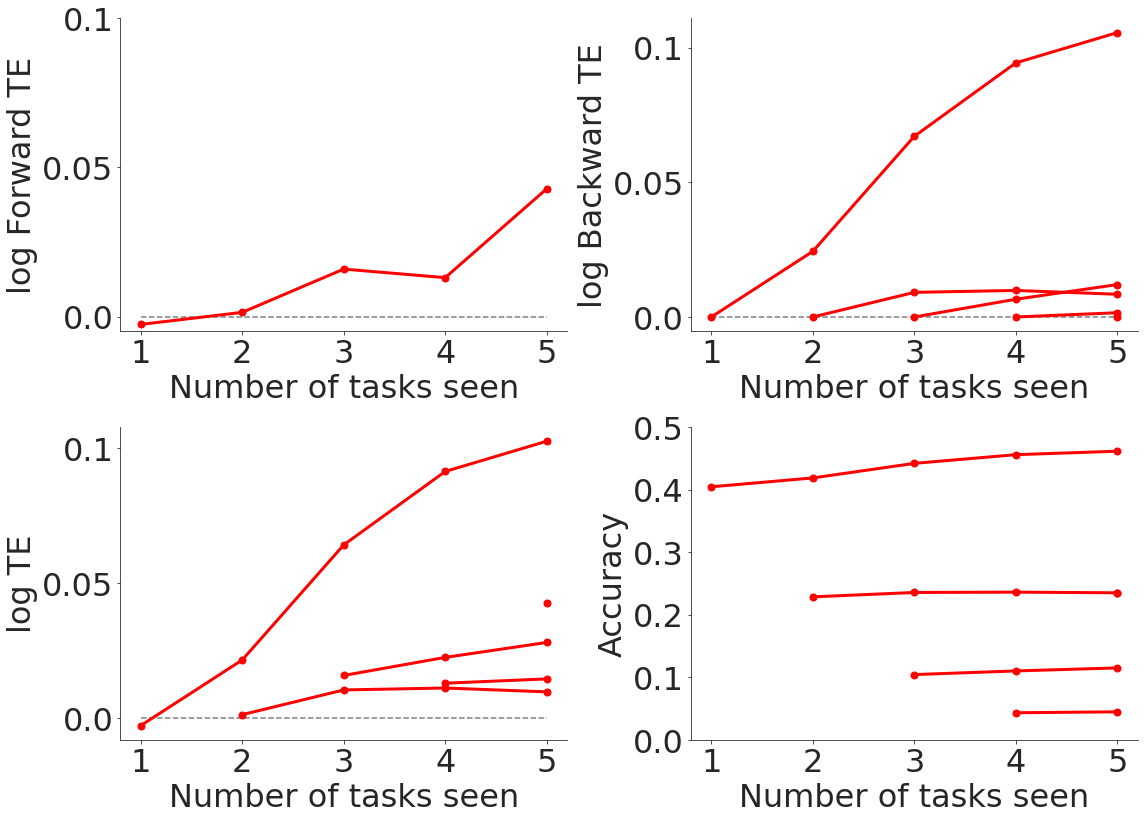

In [14]:
# set figure parameters and plot results 
sns.set_style('ticks')
clr = ["#e41a1c", "#a65628", "#377eb8", "#4daf4a", "#984ea3", "#ff7f00", "#CCCC00"]
fontsize=32
ticksize=32

fig, ax = plt.subplots(2,2, figsize=(16,11.5))
sns.despine()
sns.color_palette("Set1")

ax[0][0].plot(np.arange(1,num_tasks+1), fte, c='red', marker='.', markersize=14, linewidth=3)
ax[0][0].hlines(1, 1,num_tasks, colors='grey', linestyles='dashed',linewidth=1.5)
ax[0][0].tick_params(labelsize=ticksize)
ax[0][0].set_xlabel('Number of tasks seen', fontsize=fontsize)
ax[0][0].set_ylabel('log Forward TE', fontsize=fontsize)
ax[0][0].set_xticks(list(range(1, num_tasks+1)))
ax[0][0].set_yticks([1,1.05,1.1])
log_lbl = np.round(np.log([1,1.05,1.1]),2)
labels = [item.get_text() for item in ax[0][0].get_yticklabels()]
for ii,_ in enumerate(labels):
    labels[ii] = str(log_lbl[ii])
ax[0][0].set_yticklabels(labels)

for i in range(num_tasks):
    et = np.asarray(bte[i])
    ns = np.arange(i + 1, num_tasks + 1)
    ax[0][1].plot(ns, et, c='red', marker='.', markersize=14, linewidth=3)

ax[0][1].set_xlabel('Number of tasks seen', fontsize=fontsize)
ax[0][1].set_ylabel('log Backward TE', fontsize=fontsize)
ax[0][1].tick_params(labelsize=ticksize)
ax[0][1].hlines(1, 1,num_tasks, colors='grey', linestyles='dashed',linewidth=1.5)
ax[0][1].set_xticks(list(range(1, num_tasks+1)))
ax[0][1].set_yticks([1,1.05,1.1])
log_lbl = np.round(np.log([1,1.05,1.1]),2)
labels = [item.get_text() for item in ax[0][1].get_yticklabels()]
for ii,_ in enumerate(labels):
    labels[ii] = str(log_lbl[ii])
ax[0][1].set_yticklabels(labels)

for i in range(num_tasks):
    et = np.asarray(te[i])
    ns = np.arange(i + 1, num_tasks + 1)
    ax[1][0].plot(ns, et, c='red', marker='.', markersize=14, linewidth=3)

ax[1][0].set_xlabel('Number of tasks seen', fontsize=fontsize)
ax[1][0].set_ylabel('log TE', fontsize=fontsize)
#ax[1][0].set_xticks(np.arange(1,10))
ax[1][0].tick_params(labelsize=ticksize)
ax[1][0].hlines(1, 1,num_tasks, colors='grey', linestyles='dashed',linewidth=1.5)
ax[1][0].set_xticks(list(range(1, num_tasks+1)))
ax[1][0].set_yticks([1,1.05,1.1])
log_lbl = np.round(np.log([1,1.05,1.1]),2)
labels = [item.get_text() for item in ax[1][0].get_yticklabels()]
for ii,_ in enumerate(labels):
    labels[ii] = str(log_lbl[ii])
ax[1][0].set_yticklabels(labels)

for i in range(num_tasks):
    et = np.asarray(err[i])
    ns = np.arange(i + 1, num_tasks + 1)
    ax[1][1].plot(ns, 1-et , c='red', marker='.', markersize=14, linewidth=3)

ax[1][1].set_xlabel('Number of tasks seen', fontsize=fontsize)
ax[1][1].set_ylabel('Accuracy', fontsize=fontsize)
ax[1][1].tick_params(labelsize=ticksize)
ax[1][1].set_xticks([1,2,3,4,5])
ax[1][1].set_yticks([0, 0.1, 0.2, 0.3, 0.4, 0.5])

#fig.suptitle("Transfer Efficiency Between MNIST and Fashion-MNIST", fontsize=36)
plt.tight_layout()